In [3]:
import numpy as np
import json
from os.path import join
import matplotlib.pyplot as plt
from scipy import signal
import librosa 
import librosa.display

%matplotlib inline

In [4]:
def read_dataset(input_path, num_patients):
    data = []
    for i in range(num_patients):
        with open(join(input_path, str(i+1)+ '.json'), 'r') as f:
            data.append(json.load(f))
    return data

Read the dataset

In [5]:
input_path = join('..', 'data', 'Cuff-less Non-invasive Blood Pressure Estimation Data Set') 
n_patients = 26

data = read_dataset(input_path, n_patients)

Plot the raw signal

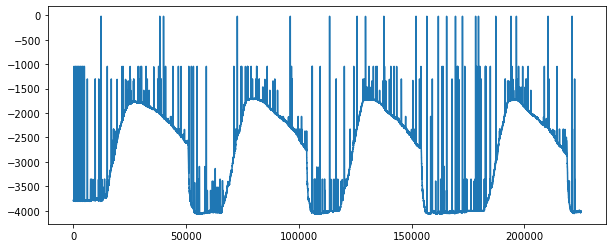

In [6]:
plt.figure(figsize=(10, 4))
data_FSR = -np.array(data[10]['data_FSR'])
plt.plot(data_FSR);

In [7]:
def moving_window(signal, window_size):
    shape = signal.shape[:-1] + (signal.shape[-1] - window_size + 1, window_size)
    strides = signal.strides + (signal.strides[-1],)
    return np.lib.stride_tricks.as_strided(signal, shape=shape, strides=strides)

In [8]:
def data_cleaning(data, max_diff=50, window_size=10):
    data_FSR = -np.array(data['data_FSR'])
    data_FSR_clear = np.array(data_FSR, dtype=np.float)
    data_FSR_outliers = np.abs(data_FSR[1:] - data_FSR[:-1]) > max_diff
    data_FSR_outliers = np.append(data_FSR_outliers, False)
    data_FSR_clear[data_FSR_outliers] = np.nan
    data_FSR_roll_mean = np.nanmean(moving_window(data_FSR_clear, window_size), axis=-1)
    data_FSR_clear[np.isnan(data_FSR_clear)] = \
    data_FSR_roll_mean[np.isnan(data_FSR_clear)[:1-window_size]]
    data_FSR_smooth = signal.savgol_filter(data_FSR_clear, 51, 0)
    return data_FSR_smooth

Clean the data set

In [9]:
cleaned_data = []

for i in range(len(data)):
    cleaned_data.append(data_cleaning(data[i]))

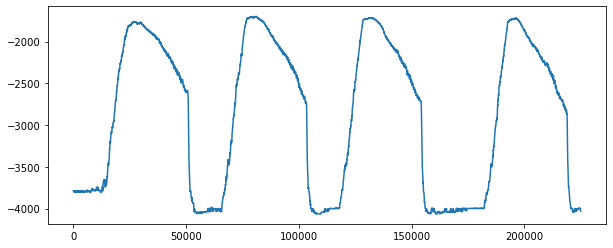

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(cleaned_data[10]);

Find windows in the signal

In [11]:
def find_mins(signal, num_mins, window_size):
    found_mins = []
    signal_max = signal.max()
    
    hwindow = window_size // 2
    
    signal = np.array(signal)

    for i in range(num_mins):
        found_min = np.argmin(signal)
        found_mins.append(found_min)
        signal[found_min-hwindow:found_min+hwindow] = signal_max
                
    return sorted(found_mins)

In [12]:
def window_finder(data, cleaned_data, diff_n=1000, roll_window = 21, min_window = 15000):
    data_FSR_diff = cleaned_data[diff_n:] - cleaned_data[:-diff_n]
    data_FSR_diff_roll = moving_window(data_FSR_diff, roll_window).mean(axis=-1)
    num_mins = len(data['data_BP'])
    data_FSR_mins = find_mins(data_FSR_diff_roll, num_mins, min_window)
    data_FSR_max, data_FSR_min = cleaned_data.max(), cleaned_data.min()
    points = [0]
    for m in data_FSR_mins:
        points.append(m + diff_n/2)
    windows = []
    for i in range(len(points)-1):
        windows.append(cleaned_data[int(points[i]):int(points[i+1])])
        
    BPs = data['data_BP']
    
    final_data = {}
    for i in range(len(BPs)):
        final_data[i] = {'window' : windows[i], 'SBP' : BPs[i]['SBP'], 'DBP' : BPs[i]['DBP']}
    return data_FSR_max, data_FSR_min, points, final_data
    

Creating Dictionary of data

In [13]:
data_FSR_max = []
data_FSR_min = []
points = []
final_data = []
for i in range(len(data)):
    data_FSR_max_i, data_FSR_min_i, points_i, final_data_i = window_finder(data[i],cleaned_data[i])
    
    data_FSR_max.append(data_FSR_max_i)
    data_FSR_min.append(data_FSR_min_i)
    points.append(points_i)
    final_data.append(final_data_i)

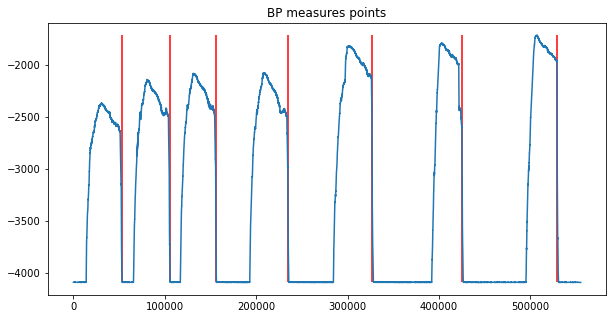

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(cleaned_data[3])
for p in points[3]:
    if p==0:
        continue
    plt.vlines(p, data_FSR_min[3], data_FSR_max[3], color='red')
plt.title('BP measures points');

Plot one window

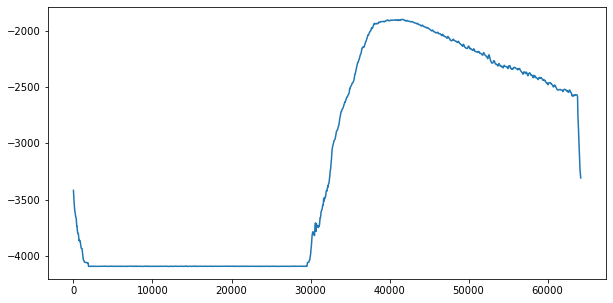

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(final_data[2][4]['window'])

In [28]:
final_data[2][3]

{'window': array([-3420.39215686, -3421.39215686, -3422.47058824, ...,
        -3417.62745098, -3418.03921569, -3418.43137255]),
 'SBP': 116,
 'DBP': 70}

Applying STFT on the signal

In [62]:
def data_STFT(data, n_fft):
    for ind,person in enumerate(data):
        for d in person:
            if len(data[ind][d]['window']) != 0:
                data[ind][d]['stft'] = librosa.amplitude_to_db(np.abs(librosa.stft(data[ind][d]['window'], n_fft)), ref=np.max)

In [63]:
fs = 100
n_fft = int(fs / 20)
data_STFT(final_data, n_fft=n_fft)
final_data[3][3]

{'window': array([-3782.15686275, -3782.35294118, -3782.54901961, ...,
        -3799.43137255, -3799.82352941, -3799.88235294]),
 'SBP': 169,
 'DBP': 90,
 'stft': array([[ -0.68960505,  -0.68927923,  -0.68887875, ...,  -0.65000559,
          -0.64955207,  -0.64955207],
        [ -6.71040633,  -6.70987912,  -6.70939811, ...,  -6.67047517,
          -6.66992147,  -6.66992147],
        [-80.        , -80.        , -80.        , ..., -80.        ,
         -80.        , -80.        ]])}